In [12]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit


In [13]:
Total_Volume = 3.0
GSH_concentration = 1.0
epsilon = 9.6
Cache_Length = 1.0


def model(t, K, S):
    return (1 - np.exp(-K * t)) * S * epsilon * Cache_Length


def fit_data(t, Abs):
    guess = [0.1, GSH_concentration]
    bounds = ([0, 0], [10, GSH_concentration])
    popt, pcov = curve_fit(
        f=model,
        xdata=t,
        ydata=Abs,
        p0=guess,
        bounds=bounds,
    )
    return popt


In [14]:
weekday_zh2en = {
    "周一": "Mon",
    "周二": "Tue",
    "周三": "Wed",
    "周四": "Thu",
    "周五": "Fri",
    "周六": "Sat",
    "周日": "Sun",
}

dataList = {
    fileName[:-4]: pd.read_csv(f"./data/{fileName}") for fileName in os.listdir("data")
}
# dataList
df = pd.DataFrame(
    {
        "Method": [],
        "Enzyme_Activity_tot": [],
        "Enzyme_Activity_avg": [],
        "S_estimate": [],
        "R_squared": [],
        "Method_Group": [],
        "Day": [],
        "Group": [],
        "Name": [],
        "Id": [],
    }
)
for label, data in dataList.items():
    Day, Group, Name, Id = label.split("-")
    t = data["Minute"].values
    for colName in data.columns[1:]:
        Abs = data[colName].values
        popt = fit_data(t, Abs)
        fit = model(t, *popt)
        K_estimate = popt[0]
        S_estimate = popt[1]
        K_tot = (1 - np.exp(-K_estimate)) * S_estimate * 3.0
        K_avg = (1 - np.exp(-K_estimate)) * S_estimate * 3.0 / 3.0
        R_squared = np.corrcoef(Abs, fit)[0, 1] ** 2
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "Method": colName,
                        "Enzyme_Activity_tot": K_tot,
                        "Enzyme_Activity_avg": K_avg,
                        "S_estimate": S_estimate,
                        "R_squared": R_squared,
                        "Method_Group": int(colName[:2] == "pH"),
                        "Day": weekday_zh2en[Day],
                        "Group": Group,
                        "Name": hex(hash(Name) + hash(Id))[-8:],
                        "Id": Id,
                    },
                    index=[0],
                ),
            ],
            ignore_index=True,
        )

# print(df)


In [15]:
df_dedup = df.drop_duplicates(subset=["Enzyme_Activity_tot", "Day", "Group", "Method"])
df_dedup.reindex()
print(df.shape)
print(df_dedup.shape)
df_dedup.groupby(["Method", "Group"]).mean()


(337, 10)
(225, 10)


Enzyme_Activity_tot  Enzyme_Activity_avg  \
Method                Group                                             
Bead mill homogenizer 1                 0.129679             0.043226   
                      2                 0.105332             0.035111   
                      3                 0.116463             0.038821   
                      4                 0.120453             0.040151   
                      5                 0.135476             0.045159   
                      6                 0.130798             0.043599   
Electric homogenizer  1                 0.123014             0.041005   
                      2                 0.116386             0.038795   
                      3                 0.117579             0.039193   
                      4                 0.111328             0.037109   
                      5                 0.120174             0.040058   
                      6                 0.139688             0.046563   
Glass homogenizer     1                 0.124818             0.041606   
                      2                 0.112813             0.037604   
                      3                 0.093923             0.031308   
                      4                 0.116365             0.038788   
                      5                 0.136728             0.045576   
                      6                 0.106509             0.035503   
pH6.0                 1                 0.104500             0.034833   
                      2                 0.080810             0.026937   
                      3                 0.080326             0.026775   
                      4                 0.092471             0.030824   
                      5                 0.089666             0.029889   
                      6                 0.098447             0.032816   
pH6.5                 1                 0.125522             0.041841   
                      2                 0.112334             0.037445   
                      3                 0.119310             0.039770   
                      4                 0.120289             0.040096   
                      5                 0.126384             0.042128   
                      6                 0.140340             0.046780   
pH7.0                 1                 0.132052             0.044017   
                      2                 0.110878             0.036959   
                      3                 0.118687             0.039562   
                      4                 0.104126             0.034709   
                      5                 0.124408             0.041469   
                      6                 0.130729             0.043576   
pH7.5                 1                 0.133292             0.044431   
                      2                 0.104541             0.034847   
                      3                 0.107603             0.035868   
                      4                 0.110283             0.036761   
                      5                 0.116820             0.038940   
                      6                 0.141111             0.047037   

                             S_estimate  R_squared  Method_Group  
Method                Group                                       
Bead mill homogenizer 1        0.254183   0.987476           0.0  
                      2        0.222118   0.999471           0.0  
                      3        0.223904   0.997636           0.0  
                      4        0.224407   0.999710           0.0  
                      5        0.223478   0.990213           0.0  
                      6        0.241589   0.999751           0.0  
Electric homogenizer  1        0.271963   0.988318           0.0  
                      2        0.225325   0.999426           0.0  
                      3        0.229974   0.986752           0.0  
                      4        0.210481   0.999845           0.0  
            

In [16]:
group_means = df_dedup.groupby(["Day", "Group"]).mean()["Enzyme_Activity_avg"]
# group_means
mean_means = group_means.mean()
# mean_means
norm_params = group_means / mean_means
# norm_params
# # normalize data based on group
df_new_column = df_dedup[["Enzyme_Activity_avg", "Day", "Group"]].copy()
for idx, params in norm_params.items():
    day, group = idx
    df_new_column.loc[
        (df_new_column["Group"] == group) & (df_new_column["Day"] == day),
        "Enzyme_Activity_avg",
    ] /= params
# add a column of noramlized data to df_dedup
df_norm = df_dedup.copy()
df_norm.insert(
    loc=list(df_dedup.columns).index("Enzyme_Activity_avg") + 1,
    column="Enzyme_Activity_avg_norm",
    value=df_new_column["Enzyme_Activity_avg"],
)
df_norm


,Method,Enzyme_Activity_tot,Enzyme_Activity_avg,Enzyme_Activity_avg_norm,S_estimate,R_squared,Method_Group,Day,Group,Name,Id
0,Electric homogenizer,0.132065,0.044022,0.041153,0.295657,0.999497,0.0,Thu,1,07c1e16f,1700018308
1,Glass homogenizer,0.111082,0.037027,0.034615,0.299049,0.999256,0.0,Thu,1,07c1e16f,1700018308
2,Bead mill homogenizer,0.102046,0.034015,0.031799,0.250307,0.998629,0.0,Thu,1,07c1e16f,1700018308
3,pH6.0,0.096306,0.032102,0.030010,0.235715,0.998904,1.0,Thu,1,07c1e16f,1700018308
4,pH6.5,0.132065,0.044022,0.041153,0.295657,0.999497,1.0,Thu,1,07c1e16f,1700018308
...,...,...,...,...,...,...,...,...,...,...,...
318,Bead mill homogenizer,0.108069,0.036023,0.042577,0.181925,0.999832,0.0,Thu,4,d00a535b,2000012259
319,pH6.0,0.073256,0.024419,0.028861,0.135133,0.999834,1.0,Thu,4,d00a535b,2000012259
320,pH6.5,0.108069,0.036023,0.042577,0.181925,0.999832,1.0,Thu,4,d00a535b,2000012259
321,pH7.0,0.104107,0.034702,0.041016,0.208286,0.999954,1.0,Thu,4,d00a535b,2000012259


Enzyme_Activity_avg_norm    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

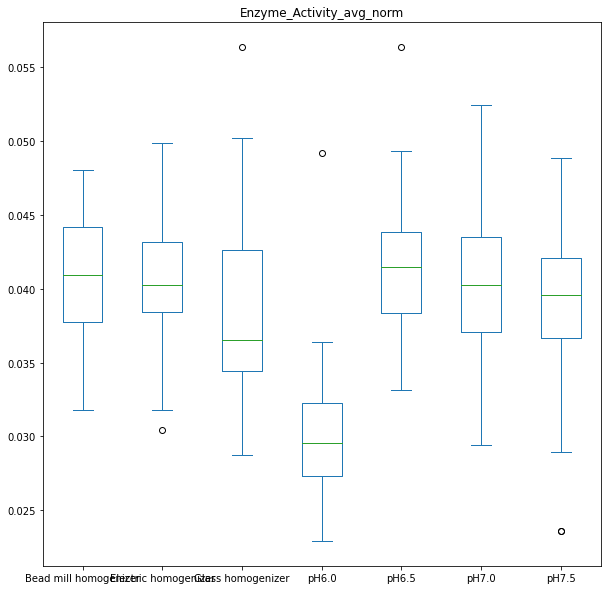

In [24]:
df_norm.plot.box(
    by="Method",
    column="Enzyme_Activity_avg_norm",
    figsize=(10, 10),
)
